# Lecture 9 : Dynamic Memory Allocation and Structured Programming

## Clone the materials repo on github to access datafiles.

In [1]:
!git clone https://code.vt.edu/jasonwil/cmda3634_materials.git

Cloning into 'cmda3634_materials'...
remote: Enumerating objects: 113, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 113 (delta 30), reused 36 (delta 15), pack-reused 47
Receiving objects: 100% (113/113), 1.27 MiB | 2.54 MiB/s, done.
Resolving deltas: 100% (38/38), done.


## Copy the lecture 9 materials into our local workspace.

In [2]:
!cp cmda3634_materials/L09/* .

# Part 1 : Sieve of Eratosthenes

## The Sieve of Erathostenes is a method for finding all prime numbers below a certain number.  

## The wiki page https://en.wikipedia.org/wiki/Sieve_of_Eratosthenes has a graphical demo showing how the algorithm works.  

## We use an integer array of size n+1 to keep track of which numbers are prime.  

## Here is our initial attempt at a C implementation.  

In [3]:
%%writefile count_primes_v1.c
#include <stdio.h>
#include <stdlib.h>

int main (int argc, char* argv[]) {

    // count number of primes <= n
    // where n is read from the command line
    if (argc < 2) {
        printf ("command usage: %s %s\n",argv[0],"n");
        return 1;
    }
    int n = atoi(argv[1]);

    // initially assume all integers >= 2 are prime
    // note that we ignore is_prime[0] and is_prime[1]
    int is_prime[n+1];
    for (int i = 2; i <= n; i++) {
        is_prime[i] = 1;
    }

    // mark non-primes <= n using Sieve of Eratosthenes
    for (int d=2;d*d<=n;d++) {
        // if d is prime, then mark multiples of d as non-prime
        // suffices to consider multiples d*d, d*d+d, d*d+2d, ...
        if (is_prime[d]) {
            for (int c=d*d;c<=n;c+=d) {
                is_prime[c] = 0;
            }
        }
    }

    // count primes
    int primes = 0;
    for (int i = 2; i <= n; i++) {
        if (is_prime[i]) {
            primes++;
        }
    }
    printf ("The number of primes <= %d is %d",n,primes);
}

Writing count_primes_v1.c


In [4]:
!gcc -o count_primes_v1 count_primes_v1.c

In [5]:
!./count_primes_v1 10

The number of primes <= 10 is 4

## Let's try n equal to one million.

In [6]:
!time ./count_primes_v1 1000000

The number of primes <= 1000000 is 78498
real	0m0.107s
user	0m0.021s
sys	0m0.003s


## Let's try n equal to ten million.

In [7]:
!time ./count_primes_v1 10000000

/bin/bash: line 1:   385 Segmentation fault      (core dumped) ./count_primes_v1 10000000

real	0m0.164s
user	0m0.003s
sys	0m0.043s


## In version 1 we put the array on the stack which severely limits how big of an n we can handle.  

## In order to handle larger n, we will need to use **dynamic memory allocation**.  

## There are **two pools of memory** that our C programs can use.  

## The first pool of memory is called the **stack** which has a very limited size.  

## If you declare an array variable using the notation *int a[100]* then the 400 bytes of memory (an int is 4 bytes) for that array is allocated on the **stack**.  

## The second pool of memory is called the **heap** which has a much larger size than the **stack**.

## Memory on the heap is accessed very differently than memory on the stack.  

## To use heap memory, we need to ask the **memory manager** for a certain number of bytes.  If those bytes are available, then the **memory manager** will return to us a pointer to the beginning of our requested memory.

## We need to **free** up our requested memory when we no longer require it.

## We interface with the **memory manager** using C functions such as **malloc**, **calloc**, and **free**.

## Here is an example illustrating the basics of dynamic memory allocation on the heap.


In [8]:
%%writefile heap.c
#include <stdio.h>
#include <stdlib.h>

int main () {

    // allocate an array of 5 integers on the stack
    int a[5];

    // allocate an array of 5 integers on the heap
    // malloc stands for "memory allocation"
    // memory allocated using malloc is not initialized.
    int* b = (int*)malloc(5*sizeof(int));

    // allocate an array of 5 integers on the stack
    // and initialize the array to contain all 0s.
    int c[5] = { 0 };

    // allocate an array of 5 integers on the heap
    // and initialize the array to contain all 0s.
    // calloc stands for "clear allocate"
    // note that the interface to calloc differs slightly
    int* d = (int*)calloc(5,sizeof(int));

    // all of these arrays can be used in the same way
    a[2] = 10;
    b[2] = 2*a[2];
    c[2] += a[2]+b[2];
    d[2] += c[2]+a[2];
    printf ("%d %d %d %d\n",a[2],b[2],c[2],d[2]);

    // Memory for stack variables is automatically
    // freed when it is no longer needed.
    // Memory for heap variables is freed manually.
    // Do not continue to use heap memory after it has been freed!
    free(b);
    free(d);
}

Writing heap.c


In [9]:
!gcc -o heap heap.c

In [10]:
!./heap

10 20 30 40


## Here is a version of our sieve code that counts primes using an array on the heap.

In [11]:
%%writefile count_primes_v2.c
#include <stdio.h>
#include <stdlib.h>

int main (int argc, char* argv[]) {

    // count number of primes <= n
    // where n is read from the command line
    if (argc < 2) {
        printf ("command usage: %s %s\n",argv[0],"n");
        return 1;
    }
    int n = atoi(argv[1]);

    // initially assume all integers >= 2 are prime
    // note that we ignore is_prime[0] and is_prime[1]
    // We dynamically allocate the array using malloc.
    // It is critical to check the return value of
    // malloc to ensure the allocation was successful.
    // If malloc is unsuccessful it will return a NULL pointer.
    // Dereferencing a NULL pointer always results in a segmentation fault!
    int* is_prime = (int*)malloc((n+1)*sizeof(int));
    if (is_prime == NULL) {
        printf ("failed to allocate is_prime array!\n");
        return 1;
    }
    for (int i = 2; i <= n; i++) {
        is_prime[i] = 1;
    }

    // mark non-primes <= n using Sieve of Eratosthenes
    for (int d=2;d*d<=n;d++) {
        // if d is prime, then mark multiples of d as non-prime
        // suffices to consider multiples d*d, d*d+d, d*d+2d, ...
        if (is_prime[d]) {
            for (int c=d*d;c<=n;c+=d) {
                is_prime[c] = 0;
            }
        }
    }

    // count primes
    int primes = 0;
    for (int i = 2; i <= n; i++) {
        if (is_prime[i]) {
            primes++;
        }
    }
    printf ("The number of primes <= %d is %d",n,primes);

    // free the dynamically allocated array
    free(is_prime);
}


Writing count_primes_v2.c


## Let's switch on the optimizing compiler using -O3 and -march=native for better performance.

In [12]:
!gcc -O3 -march=native -o count_primes_v2 count_primes_v2.c

## Let's try n equal to one hundred million.

In [13]:
!time ./count_primes_v2 100000000

The number of primes <= 100000000 is 5761455
real	0m3.903s
user	0m2.030s
sys	0m0.391s


## Let's try n equal to one billion.

## In this case our **is_prime** array is roughly 4 billion bytes or 4 Gigabytes!

In [14]:
!time ./count_primes_v2 1000000000

The number of primes <= 1000000000 is 50847534
real	0m28.680s
user	0m24.538s
sys	0m3.101s


## By contrast, the stack size is 8192 kilobytes which is roughly 8 Megabytes.

In [15]:
!ulimit -s

8192


# Part 2 : Finding the Extreme Pair of Points in $\mathbb{R}^d$

## To find the extreme pair we will need to maximize $$\| \mathbf{u} - \mathbf{v} \|$$

## which is equivalent to maximizing $$\| \mathbf{u} - \mathbf{v} \|^2$$

## Here is our code from the previous lecture for solving this problem in two dimensions.


In [16]:
%%writefile extreme_v1.c
#include <stdio.h>
#include <stdlib.h>

typedef struct {
    float x,y;
} vec2;

float vec2_dist_sq (vec2 u, vec2 v) {
    return (u.x-v.x)*(u.x-v.x)+(u.y-v.y)*(u.y-v.y);
}

void vec2_read_dataset (vec2* data, int len) {
    for (int i=0;i<len;i++) {
        if (scanf("%f %f",&(data[i].x),&(data[i].y)) != 2) {
            printf ("error reading dataset\n");
            exit (1);
        }
    }
}

typedef struct {
    float max_dist_sq;
    int extreme_1, extreme_2;
} extreme_info;

extreme_info extreme_pair (vec2* data, int num_points) {
    extreme_info info = { 0, -1, -1 };
    for (int i=0;i<num_points-1;i++) {
        for (int j=i+1;j<num_points;j++) {
            float dist_sq = vec2_dist_sq(data[i],data[j]);
            if (dist_sq > info.max_dist_sq) {
                info.max_dist_sq = dist_sq;
                info.extreme_1 = i;
                info.extreme_2 = j;
            }
        }
    }
    return info;
}

int main () {

    // read dataset
    int len;
    if (scanf("%d",&len) != 1) {
        printf ("error reading the length of the dataset\n");
        return 1;
    }
    vec2 data[len];
    vec2_read_dataset (data,len);

    // find the extreme pair
    extreme_info info;
    info = extreme_pair(data,len);

    // print the results
    printf ("The extreme pair has indices (%d,%d)\n",info.extreme_1,info.extreme_2);
    printf ("The distance squared between the extreme pair is %g\n",info.max_dist_sq);
}

Writing extreme_v1.c


## Note that version 1 has **hard coded** the dimension of the dataset to 2.  

## We will fix this problem in version 2 by writing an extreme code that works for any dimension $d$.

## As in version 1, we will store the set of vectors in $\mathbb{R}^d$ using an array of C structures.

## Since the size of an array definied inside a C structure needs to be defined at **compile time**, we will use a **compile flag** to specify the dimension $d$.

## To provide error checking we all add the dimesion of the dataset to our data files.  

## In particular, the first line of the data file will contain two integers.  

## The first integer on the first line gives the number of points in the dataset

## The second integer on the first line gives the dimension of the data.

## As an example, here are the first 5 lines of the data file *points1k.txt*.

In [17]:
!head -5 points1k.txt

1000 2
0.62805 0.82095
1.28147 0.33027
0.65534 0.95499
1.11772 0.99745


## We make two additional modifications to version 2.

* ## We store our data using type double intead of type float to increase accuracy.  Note that when using *scanf* to read a double we use the format specifier *%lf*.

* ## We report the actual distance between the extreme pair rather than the distance squared.  Note that we need to include the math library using *#include <math.h>* and link the math library using the compile option *-lm*.

In [18]:
%%writefile extreme_v2.c
#include <stdio.h>
#include <stdlib.h>
#include <math.h>

#ifndef DIM
#define DIM 2
#endif

typedef struct {
    double x[DIM];
} vecd;

double vecd_dist_sq (vecd u, vecd v) {
    double dist_sq = 0;
    for (int i=0;i<DIM;i++) {
        dist_sq += (u.x[i]-v.x[i])*(u.x[i]-v.x[i]);
    }
    return dist_sq;
}

void vecd_read_dataset (vecd* data, int len) {
    for (int i=0;i<len;i++) {
        for (int j=0;j<DIM;j++) {
            if (scanf("%lf",&(data[i].x[j])) != 1) {
                printf ("error reading dataset\n");
                exit(1);
            }
        }
    }
}

typedef struct {
    double max_dist_sq;
    int extreme_1, extreme_2;
} extreme_info;

extreme_info extreme_pair (vecd* data, int num_points) {
    extreme_info info = { 0, -1, -1 };
    for (int i=0;i<num_points-1;i++) {
        for (int j=i+1;j<num_points;j++) {
            double dist_sq = vecd_dist_sq(data[i],data[j]);
            if (dist_sq > info.max_dist_sq) {
                info.max_dist_sq = dist_sq;
                info.extreme_1 = i;
                info.extreme_2 = j;
            }
        }
    }
    return info;
}

int main () {

    // read dataset
    int len, dim;
    if (scanf("%d %d",&len,&dim) != 2) {
        printf ("error reading the length and dimension of the dataset\n");
        return 1;
    }
    if (dim != DIM) {
        printf ("dimension of dataset does not match DIM\n");
        return 1;
    }
    vecd data[len];
    vecd_read_dataset (data,len);

    // find the extreme pair
    extreme_info info;
    info = extreme_pair(data,len);

    // print the results
    printf ("The extreme pair has indices (%d,%d)\n",info.extreme_1,info.extreme_2);
    printf ("The distance between the extreme pair is %.2f\n",sqrt(info.max_dist_sq));
}

Writing extreme_v2.c


## Let's first test our code on the small 2d dataset from the previous lecture.  

In [19]:
!gcc -o extreme_v2 extreme_v2.c -lm

In [20]:
!cat points10.txt | ./extreme_v2

The extreme pair has indices (5,8)
The distance between the extreme pair is 8.25


## Next let's test on a dataset containing 1000 points in two dimensions.

In [21]:
!cat points1k.txt | ./extreme_v2

The extreme pair has indices (446,911)
The distance between the extreme pair is 2.78


## Let's use Python to visualize the result.

In [22]:
!cat points1k.txt | python3 extreme.py points1k.png 446 911

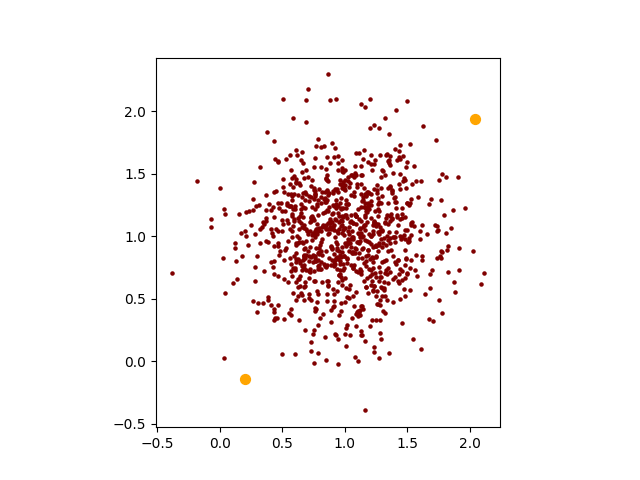

In [23]:
from IPython import display
display.Image("points1k.png")

## Next let's try a set of MNIST images.

## Each MNIST image is 28 rows by 28 columns.  

## We flatten each image into a 784 dimension vector of grayscale intensity values.

In [24]:
!head -2 mnist1000.txt

1000 784
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 18 18 18 126 136 175 26 166 255 247 127 0 0 0 0 0 0 0 0 0 0 0 0 30 36 94 154 170 253 253 253 253 253 225 172 253 242 195 64 0 0 0 0 0 0 0 0 0 0 0 49 238 253 253 253 253 253 253 253 253 251 93 82 82 56 39 0 0 0 0 0 0 0 0 0 0 0 0 18 219 253 253 253 253 253 198 182 247 241 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 80 156 107 253 253 205 11 0 43 154 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 14 1 154 253 90 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 139 253 190 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 11 190 253 70 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 35 241 225 160 108 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 81 240 253 253 119 25 0 0 0 0 0 0 0 0 0 0 0 0 

## To work with MNIST images we need to set our DIM compile flag to 784.  

In [25]:
!gcc -DDIM=784 -o extreme_v2 extreme_v2.c -lm

In [26]:
!cat mnist1000.txt | ./extreme_v2

The extreme pair has indices (121,426)
The distance between the extreme pair is 3797.52


## We can visualize the extreme pair of MNIST images using Python.

In [27]:
!cat mnist1000.txt | python3 mnist.py extreme.png 121 426

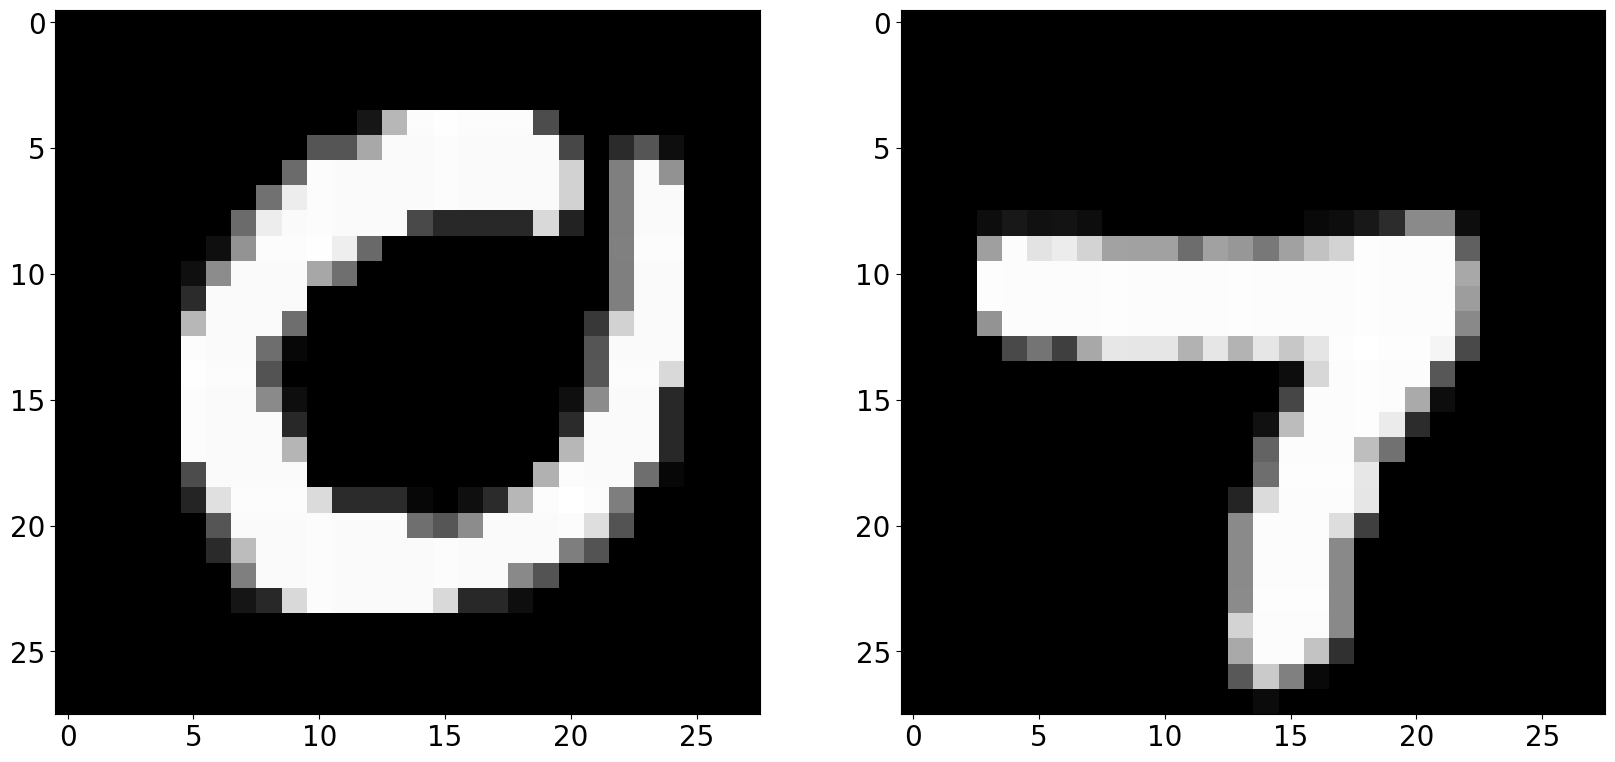

In [28]:
from IPython import display
display.Image("extreme.png")

## Let's next try a dataset containing 2000 MNIST images.

In [29]:
!cat mnist2000.txt | ./extreme_v2

/bin/bash: line 1:   596 Broken pipe             cat mnist2000.txt
       597 Segmentation fault      (core dumped) | ./extreme_v2


## What caused the segmentation fault?  

## Hint 1: How many bytes is the *vecd data[len]* array in this case?

## Hint 2: Remember that the stack size is 8192 kilobytes.  

In [30]:
!ulimit -s

8192


## In version 3 of our extreme code, we put the dataset array on the heap instead of the stack.

In [31]:
%%writefile extreme_v3.c
#include <stdio.h>
#include <stdlib.h>
#include <math.h>

#ifndef DIM
#define DIM 2
#endif

typedef struct {
    double x[DIM];
} vecd;

double vecd_dist_sq (vecd u, vecd v) {
    double dist_sq = 0;
    for (int i=0;i<DIM;i++) {
        dist_sq += (u.x[i]-v.x[i])*(u.x[i]-v.x[i]);
    }
    return dist_sq;
}

void vecd_read_dataset (vecd* data, int len) {
    for (int i=0;i<len;i++) {
        for (int j=0;j<DIM;j++) {
            if (scanf("%lf",&(data[i].x[j])) != 1) {
                printf ("error reading dataset\n");
                exit(1);
            }
        }
    }
}

typedef struct {
    double max_dist_sq;
    int extreme_1, extreme_2;
} extreme_info;

extreme_info extreme_pair (vecd* data, int num_points) {
    extreme_info info = { 0, -1, -1 };
    for (int i=0;i<num_points-1;i++) {
        for (int j=i+1;j<num_points;j++) {
            double dist_sq = vecd_dist_sq(data[i],data[j]);
            if (dist_sq > info.max_dist_sq) {
                info.max_dist_sq = dist_sq;
                info.extreme_1 = i;
                info.extreme_2 = j;
            }
        }
    }
    return info;
}

int main () {

    // read dataset
    int len, dim;
    if (scanf("%d %d",&len,&dim) != 2) {
        printf ("error reading the length and dimension of the dataset\n");
        return 1;
    }
    if (dim != DIM) {
        printf ("dimension of dataset does not match DIM\n");
        return 1;
    }
    // allocate the data array on the heap using malloc
    // note that sizeof(vecd) is the number of bytes required
    // to store a variable of type vecd.
    vecd* data = (vecd*)malloc(len*sizeof(vecd));
    vecd_read_dataset (data,len);

    // find the extreme pair
    extreme_info info;
    info = extreme_pair(data,len);

    // print the results
    printf ("The extreme pair has indices (%d,%d)\n",info.extreme_1,info.extreme_2);
    printf ("The distance between the extreme pair is %.2f\n",sqrt(info.max_dist_sq));

    // free the data array
    free (data);
}

Writing extreme_v3.c


In [32]:
!gcc -DDIM=784 -o extreme_v3 extreme_v3.c -lm

In [50]:
!time cat mnist2000.txt | ./extreme_v3

The extreme pair has indices (1618,1895)
The distance between the extreme pair is 3928.75

real	0m7.911s
user	0m7.759s
sys	0m0.028s


In [34]:
!cat mnist2000.txt | python3 mnist.py extreme2.png 1618 1895

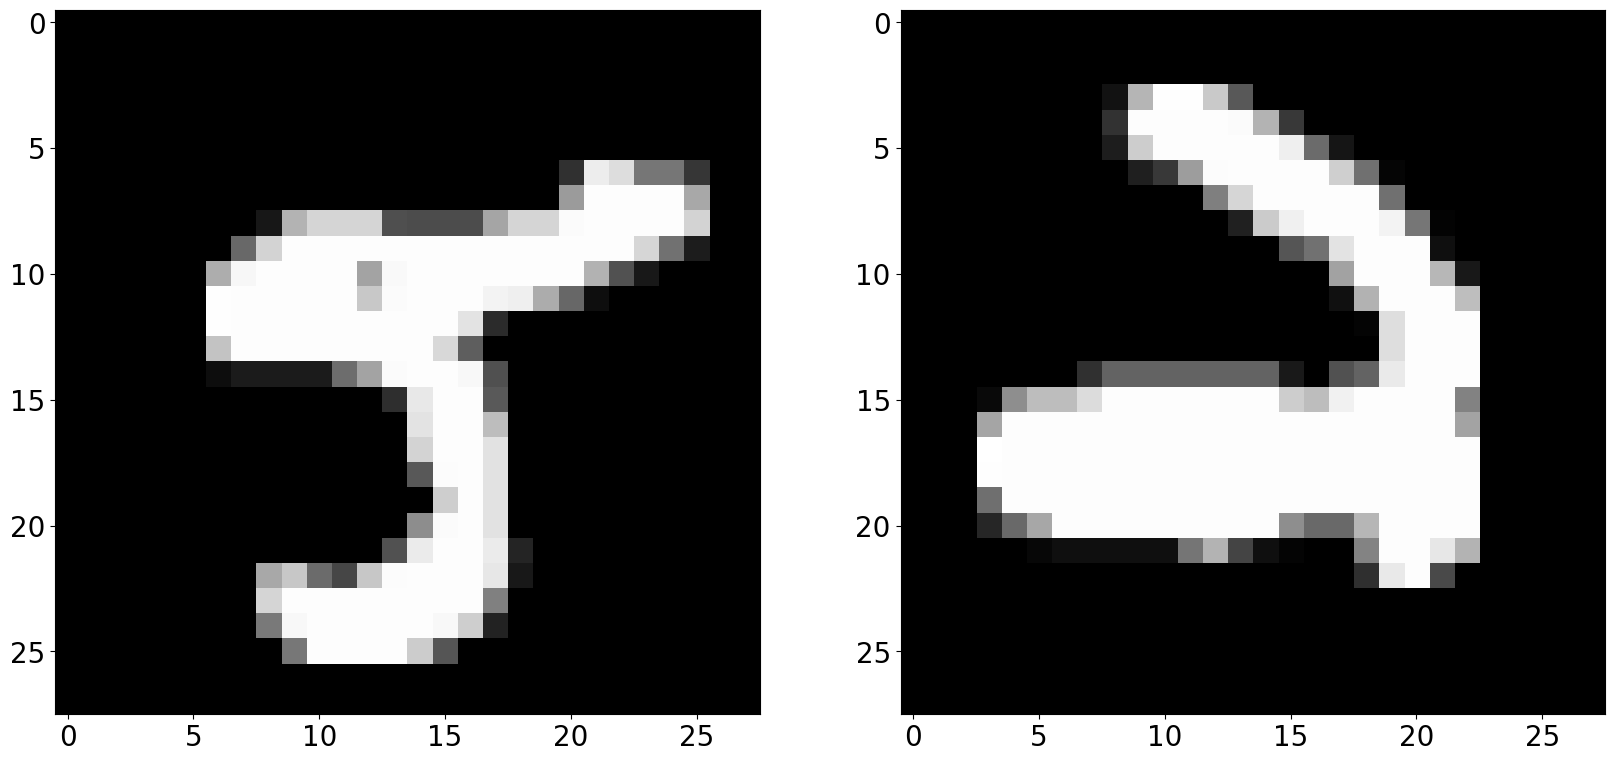

In [35]:
from IPython import display
display.Image("extreme2.png")

## Version 3 now works for large datasets.

## However, why is it not a good idea to pass the vectors *u* and *v* by value to the function *vec2_dist_sq*?
    double vecd_dist_sq (vecd u, vecd v) {

## In version 4, we make a performance improvement by passing *u* and *v* by pointer instead.


In [36]:
%%writefile extreme_v4.c
#include <stdio.h>
#include <stdlib.h>
#include <math.h>

#ifndef DIM
#define DIM 2
#endif

typedef struct {
    double x[DIM];
} vecd;

double vecd_dist_sq (vecd* u, vecd* v) {
    double dist_sq = 0;
    for (int i=0;i<DIM;i++) {
        dist_sq += (u->x[i]-v->x[i])*(u->x[i]-v->x[i]);
    }
    return dist_sq;
}

void vecd_read_dataset (vecd* data, int len) {
    for (int i=0;i<len;i++) {
        for (int j=0;j<DIM;j++) {
            if (scanf("%lf",&(data[i].x[j])) != 1) {
                printf ("error reading dataset\n");
                exit(1);
            }
        }
    }
}

typedef struct {
    double max_dist_sq;
    int extreme_1, extreme_2;
} extreme_info;

extreme_info extreme_pair (vecd* data, int num_points) {
    extreme_info info = { 0, -1, -1 };
    for (int i=0;i<num_points-1;i++) {
        for (int j=i+1;j<num_points;j++) {
            double dist_sq = vecd_dist_sq(&(data[i]),&(data[j]));
            if (dist_sq > info.max_dist_sq) {
                info.max_dist_sq = dist_sq;
                info.extreme_1 = i;
                info.extreme_2 = j;
            }
        }
    }
    return info;
}

int main () {

    // read dataset
    int len, dim;
    if (scanf("%d %d",&len,&dim) != 2) {
        printf ("error reading the length and dimension of the dataset\n");
        return 1;
    }
    if (dim != DIM) {
        printf ("dimension of dataset does not match DIM\n");
        return 1;
    }
    // allocate the data array on the heap using malloc
    // note that sizeof(vecd) is the number of bytes required
    // to store a variable of type vecd.
    vecd* data = (vecd*)malloc(len*sizeof(vecd));
    vecd_read_dataset (data,len);

    // find the extreme pair
    extreme_info info;
    info = extreme_pair(data,len);

    // print the results
    printf ("The extreme pair has indices (%d,%d)\n",info.extreme_1,info.extreme_2);
    printf ("The distance between the extreme pair is %.2f\n",sqrt(info.max_dist_sq));

    // free the data array
    free (data);
}

Writing extreme_v4.c


In [51]:
!gcc -DDIM=784 -o extreme_v4 extreme_v4.c -lm

In [52]:
!time cat mnist2000.txt | ./extreme_v4

The extreme pair has indices (1618,1895)
The distance between the extreme pair is 3928.75

real	0m6.340s
user	0m6.307s
sys	0m0.020s


## That small change reduced the runtime by around 1.5 seconds.

## We can further boost performance by compiling with the optimization flags turned on.

In [39]:
!gcc -O3 -ffast-math -march=native -DDIM=784 -o extreme_v4 extreme_v4.c -lm

In [40]:
!time cat mnist2000.txt | ./extreme_v4

The extreme pair has indices (1618,1895)
The distance between the extreme pair is 3928.75

real	0m0.902s
user	0m0.878s
sys	0m0.021s


## We can use a simple shell script to store our compile command in a file.  

## We can run the shell script using the *bash* command.

## The *$1* is placeholder for a command line argument that specifies the dimension of our dataset.

In [41]:
%%writefile build_v4.sh
gcc -O3 -ffast-math -march=native -DDIM=$1 -o extreme_v4 extreme_v4.c -lm

Writing build_v4.sh


In [42]:
!bash build_v4.sh 784

In [43]:
!time cat mnist2000.txt | ./extreme_v4

The extreme pair has indices (1618,1895)
The distance between the extreme pair is 3928.75

real	0m0.947s
user	0m0.918s
sys	0m0.019s


## Part 3 : Using Header and Implementation Files

## As projects become more complicated we will avoid putting all of our code in a single source file.  

## We can use header (or interface) files (i.e. *.h*) and implementation files (i.e. *.c*) to move related type declarations and functions to their own files.  

## What type declarations and functions are related in our extreme code?

## Let's get started with version 5 by first creating a *.h* file for our *vecd* type declation and interfaces.

## Note that we use the flag *VECD_H* to avoid having multiple copies of our header file included.  

## Multiple includes can happen if multiple header files are included that include the same header file.  

## This problem is more common on larger projects but it is good to get into the habit of preventing multiple includes now.  

## Note that the header file only contains type declarations and function *interfaces*.

## We typically avoid specifying *implementations* in our header files.

In [44]:
%%writefile vecd.h
#ifndef VECD_H
#define VECD_H

#ifndef DIM
#define DIM 2
#endif

typedef struct {
    double x[DIM];
} vecd;

double vecd_dist_sq (vecd* u, vecd* v);

void vecd_read_dataset (vecd* data, int len);

#endif

Writing vecd.h


## Here is the corresponding *implementation* file.

In [45]:
%%writefile vecd.c
#include <stdio.h>
#include <stdlib.h>
#include "vecd.h"

double vecd_dist_sq (vecd* u, vecd* v) {
    double dist_sq = 0;
    for (int i=0;i<DIM;i++) {
        dist_sq += (u->x[i]-v->x[i])*(u->x[i]-v->x[i]);
    }
    return dist_sq;
}

void vecd_read_dataset (vecd* data, int len) {
    for (int i=0;i<len;i++) {
        for (int j=0;j<DIM;j++) {
            if (scanf("%lf",&(data[i].x[j])) != 1) {
                printf ("error reading dataset\n");
                exit(1);
            }
        }
    }
}

Writing vecd.c


## Finally, here is our main source file that takes advantage of the separation of the *vecd* functionality.

In [46]:
%%writefile extreme_v5.c
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include "vecd.h"

typedef struct {
    double max_dist_sq;
    int extreme_1, extreme_2;
} extreme_info;

extreme_info extreme_pair (vecd* data, int num_points) {
    extreme_info info = { 0, -1, -1 };
    for (int i=0;i<num_points-1;i++) {
        for (int j=i+1;j<num_points;j++) {
            double dist_sq = vecd_dist_sq(&(data[i]),&(data[j]));
            if (dist_sq > info.max_dist_sq) {
                info.max_dist_sq = dist_sq;
                info.extreme_1 = i;
                info.extreme_2 = j;
            }
        }
    }
    return info;
}

int main () {

    // read dataset
    int len, dim;
    if (scanf("%d %d",&len,&dim) != 2) {
        printf ("error reading the length and dimension of the dataset\n");
        return 1;
    }
    if (dim != DIM) {
        printf ("dimension of dataset does not match DIM\n");
        return 1;
    }
    // allocate the data array on the heap using malloc
    // note that sizeof(vecd) is the number of bytes required
    // to store a variable of type vecd.
    vecd* data = (vecd*)malloc(len*sizeof(vecd));
    vecd_read_dataset (data,len);

    // find the extreme pair
    extreme_info info;
    info = extreme_pair(data,len);

    // print the results
    printf ("The extreme pair has indices (%d,%d)\n",info.extreme_1,info.extreme_2);
    printf ("The distance between the extreme pair is %.2f\n",sqrt(info.max_dist_sq));

    // free the data array
    free (data);
}

Writing extreme_v5.c


## To build our new program we need to add the source file *vecd.c* to our compile command.

In [47]:
%%writefile build_v5.sh
gcc -O3 -ffast-math -march=native -DDIM=$1 -o extreme_v5 extreme_v5.c vecd.c -lm

Writing build_v5.sh


In [48]:
!bash build_v5.sh 784

In [49]:
!time cat mnist2000.txt | ./extreme_v5

The extreme pair has indices (1618,1895)
The distance between the extreme pair is 3928.75

real	0m0.968s
user	0m0.929s
sys	0m0.024s
